In [3]:
import cv2 as cv
import matplotlib.pyplot as plt
import csv

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

inWidth = 368
inHeight = 368
inScale = 1

thr = 0.2

BODY_PARTS = {"Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
              "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
              "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
              "LEye": 15, "REar": 16, "LEar": 17, "Background": 18}

POSE_PAIRS = [["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
              ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
              ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
              ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
              ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"]]

#Import image

#img = cv.imread("pose.png")
#plt.imshow(img)
#plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))


def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                               (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inp)
    out = net.forward()

    assert (len(BODY_PARTS) <= out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        # Originally, we try to find all the local maximums. To simplify a sample
        # we just find a global one. However only a single pose at the same time
        # could be detected this way.
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]

        # Add a point if it's confidence is higher than threshold.
        points.append((int(x), int(y)) if conf > thr else None)

    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert (partFrom in BODY_PARTS)
        assert (partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()
    freq = cv.getTickFrequency() / 1000
    cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
    return frame



#estimated_image = pose_estimation(img)
#plt.imshow(cv.cvtColor(estimated_image, cv.COLOR_BGR2RGB))

#Video
vidcoordinates = []

vidvalue = []
vidnames=[]
namessubjects = ['']
for i in range(5):
    for j in range(5):
        vidvalue.append(i)
        vidnames.append(f'Pares i arm right {i} - 1080 50fps - {j+1}_Trim.mp4')
print(vidnames)
#vidnamess = ['Pares i arm right 3 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 2_Trim.mp4']
#vidnamess = ['nataliepeka1_1_20.mp4', 'nataliepeka1_4_20.mp4']
for i in vidnames:
    allpoints = []
    cap = cv.VideoCapture(i)
    cap.set(3, 800)
    cap.set(4, 800)

    if not cap.isOpened():
        cap = cv.VideoCapture(0)
    if not cap.isOpened():
        raise IOError('Cannot open video')
    while cv.waitKey(1) < 0:
        hasFrame, frame = cap.read()
        if not hasFrame:
            cv.waitKey()
            break
        frameWidth = frame.shape[1]
        frameHeight = frame.shape[0]
        inp = cv.dnn.blobFromImage(frame, inScale, (inWidth, inHeight),
                                   (0, 0, 0), swapRB=False, crop=False)
        net.setInput(inp)
        out = net.forward()

        assert (len(BODY_PARTS) <= out.shape[1])

        points = []
        for i in range(len(BODY_PARTS)):
            # Slice heatmap of corresponding body's part.
            heatMap = out[0, i, :, :]

            # Originally, we try to find all the local maximums. To simplify a sample
            # we just find a global one. However only a single pose at the same time
            # could be detected this way.
            _, conf, _, point = cv.minMaxLoc(heatMap)
            x = (frameWidth * point[0]) / out.shape[3]
            y = (frameHeight * point[1]) / out.shape[2]

            # Add a point if it's confidence is higher than threshold.
            points.append((int(x), int(y)) if conf > thr else None)

        for pair in POSE_PAIRS:
            partFrom = pair[0]
            partTo = pair[1]
            assert (partFrom in BODY_PARTS)
            assert (partTo in BODY_PARTS)

            idFrom = BODY_PARTS[partFrom]
            idTo = BODY_PARTS[partTo]

            if points[idFrom] and points[idTo]:
                cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
                cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
                cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

        t, _ = net.getPerfProfile()
        freq = cv.getTickFrequency() / 2000
        cv.putText(frame, '%.2fms' % (t / freq), (10, 20), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0))
        #print(points)
        #cv.imshow('Pose estimation Tutorial', frame)
        
        if points[4] is not None:
            print(points[4][1])
            allpoints.append(points[4][1])
    vidcoordinates.append(allpoints)
    print(allpoints)
#print(vidcoordinates)


input_variable=[]
for i in range(5):
    input_variable.append(vidcoordinates[i])

with open ('coordinates_data.csv','w',newline = '') as csvfile:
    my_writer = csv.writer(csvfile, delimiter = ' ')
    my_writer.writerows(input_variable)

['Pares i arm right 0 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 0 - 1080 50fps - 2_Trim.mp4', 'Pares i arm right 0 - 1080 50fps - 3_Trim.mp4', 'Pares i arm right 0 - 1080 50fps - 4_Trim.mp4', 'Pares i arm right 0 - 1080 50fps - 5_Trim.mp4', 'Pares i arm right 1 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 1 - 1080 50fps - 2_Trim.mp4', 'Pares i arm right 1 - 1080 50fps - 3_Trim.mp4', 'Pares i arm right 1 - 1080 50fps - 4_Trim.mp4', 'Pares i arm right 1 - 1080 50fps - 5_Trim.mp4', 'Pares i arm right 2 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 2 - 1080 50fps - 2_Trim.mp4', 'Pares i arm right 2 - 1080 50fps - 3_Trim.mp4', 'Pares i arm right 2 - 1080 50fps - 4_Trim.mp4', 'Pares i arm right 2 - 1080 50fps - 5_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 1_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 2_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 3_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 4_Trim.mp4', 'Pares i arm right 3 - 1080 50fps - 5_Trim.mp4', 'Pares i arm right 

422
446
446
446
469
469
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
469
469
469
446
446
446
446
446
446
446
469
469
469
469
469
469
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
469
446
469
469
469
446
469
469
446
446
446
469
446
469
469
469
446
446
446
446
446
446
446
469
446
446
446
446
446
446
446
446
446
446
469
469
469
446
446
446
446
446
446
446
446
446
469
469
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
469
446
446
446
446
446
469
469
469
469
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
469
446
446
446
446
446
446
446
446
446
446
469
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
422
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
422
422
422
422
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
422
422
422
446
446
446
446


727
727
727
704
704
704
680
657
633
610
586
563
540
540
493
493
446
422
422
399
399
399
422
422
422
422
422
422
422
422
422
422
422
422
422
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
446
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
493
469
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
516
493
493
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
540
540
516
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
563
586
586
586
586
586
586
586
586
586
586
610
610
610
610
610
610
610
610
610
610
610
610
610
610
610
610
610
610
610
610
633
633
633
633
633
633
633
633
633
633


751
727
727
727
704
680
657
633
610
586
586
563
540
540
516
516
493
469
469
446
446
422
422
399
399
422
422
399
399
399
375
399
399
375
375
375
399
399
399
399
399
375
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
399
422
422
422
446
446
446
446
446
446
446
446
422
446
446
446
446
446
446
446
469
446
469
469
469
469
469
469
469
446
446
446
446
446
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
469
493
469
493
493
469
493
493
493
493
493
493
493
493
493
493
493
493
469
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
516
493
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
563
563
563
563
563
586
563
563
563
563
563
563
586
586
586
586
586
586
586
586


493
469
446
446
446
446
446
446
446
446
446
446
446
446
469
469
469
469
469
469
469
469
469
469
493
469
493
469
493
493
493
469
469
469
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
493
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
516
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
563
563
563
540
563
563
563
563
563
563
563
563
563
563
563
563
563
586
586
586
586
586
586
586
586
586
586
586
586
586
586
610
610
610
610
610
610
610
633
633
633
633
610
610
610
633
633
633
633
633
633
633
633
633
633
633
633
657
657
657
657
657
657
657
680
680
680
680
680
680
680
680
704
704
704
704
727
727
727
727
727
727
727
727
727
727
727
727
727
727
727
727
727
751
751
751
751
751
751
751
774
774
774
774
774
774
774
774
774
798
774
798
798
798
821
845
845
821
774
774
821
868
868
868
868
868
845
845
845
845
845
821
798
798
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845


727
704
751
751
610
586
563
540
540
540
516
516
516
493
516
493
493
493
493
469
469
469
493
469
469
493
493
493
493
493
493
493
493
493
493
493
493
493
516
493
516
493
493
516
516
516
516
516
516
516
516
516
516
516
516
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
540
563
563
563
563
563
563
563
563
586
586
586
586
610
610
610
610
610
610
633
633
633
633
633
633
633
633
633
633
633
633
657
657
657
657
657
657
657
657
680
680
680
680
680
680
680
704
704
704
680
704
704
727
727
727
727
727
727
751
751
751
751
751
751
751
751
751
774
751
774
774
774
774
774
774
774
798
798
798
798
798
798
798
821
821
821
821
845
821
821
845
868
845
821
845
821
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
868
868
868
868
868
868
868
845
868
868
845


845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
[774, 845, 845, 845, 845, 845, 845, 845, 845, 563, 821, 821, 798, 774, 774, 680, 633, 516, 516, 493, 540, 493, 446, 422, 399, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 352, 375, 375, 352, 375, 375, 375, 375, 375, 375, 375, 375, 399, 375, 375, 375, 375, 375, 375, 399, 399, 399, 375, 375, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 399, 422, 422, 446, 469, 493, 516, 563, 586, 727, 751, 868, 540, 798, 774, 774, 774, 845, 845, 845, 540, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 774, 845, 774, 774, 774, 845, 845, 774, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845, 845]
868
868
868
868
868
868
868
845
845
845
845
845
845
845
868
868
868
868
868
868
868
868
868
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845
845

845
845
845
774
845
845
845
845
845
845
774
774
774
774
868
774
868
868
868
868
868
868
868
845
845
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868
868


In [5]:
print(vidcoordinates)

[[610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 633, 633, 633, 633, 610, 610, 586, 563, 540, 516, 563, 540, 516, 469, 446, 446, 422, 422, 422, 422, 422, 422, 422, 422, 446, 446, 446, 446, 446, 469, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 469, 446, 469, 446, 446, 446, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 469, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 469, 469, 446, 446, 446, 446, 446, 446, 446, 446

In [29]:
lengths = []
for i in vidcoordinates:
    lengths.append(len(i))
print(lengths)
print(max(lengths))

for i in vidcoordinates:
    while len(i) < max(lengths):
        i.append(0)
print(vidcoordinates)

[394, 370, 326, 341, 303, 311, 314, 316, 322, 330, 334, 295, 333, 318, 343, 119, 151, 131, 111, 144, 234, 199, 256, 130, 333]
394
[[610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 610, 633, 633, 633, 633, 610, 610, 586, 563, 540, 516, 563, 540, 516, 469, 446, 446, 422, 422, 422, 422, 422, 422, 422, 422, 446, 446, 446, 446, 446, 469, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 469, 446, 469, 446, 446, 446, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 469, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 469, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446, 446

In [41]:
vidvalue = []
for i in range(5):
    for j in range(5):
        vidvalue.append(i)
print(vidvalue)
vidvalue10 = [0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
print(vidvalue10)

[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4]
[0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [51]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from tensorflow.keras import datasets, layers, models
import tensorflow as tf

import numpy as np

y = np.array(vidvalue10)
X = np.array(vidcoordinates)



X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
#X_train, X_test = X_train / 1080.0, X_test / 1080.0
print(X_train)
print(y_train)
#Gammalt

X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)

model = tf.keras.models.Sequential([
  #tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.1),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              #loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
fit_info = model.fit(X_train, y_train,
           batch_size=25,
           epochs=5,
           verbose=1,
           validation_data=(X_test, y_test))

model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

[[610 610 610 ...   0   0   0]
 [868 868 868 ...   0   0   0]
 [727 727 727 ...   0   0   0]
 ...
 [727 704 751 ...   0   0   0]
 [774 845 845 ...   0   0   0]
 [704 680 680 ...   0   0   0]]
[0 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 1 1]
Epoch 1/5
1/1 [==============================] - 1s 1s/step - loss: 840.7408 - accuracy: 0.0556 - val_loss: 99.2874 - val_accuracy: 0.5714
Epoch 2/5
1/1 [==============================] - 0s 82ms/step - loss: 102.7425 - accuracy: 0.4444 - val_loss: 142.1311 - val_accuracy: 0.8571
Epoch 3/5
1/1 [==============================] - 0s 79ms/step - loss: 284.2773 - accuracy: 0.7778 - val_loss: 157.2470 - val_accuracy: 0.8571
Epoch 4/5
1/1 [==============================] - 0s 79ms/step - loss: 301.7453 - accuracy: 0.7778 - val_loss: 124.9711 - val_accuracy: 0.8571
Epoch 5/5
1/1 [==============================] - 0s 94ms/step - loss: 244.4671 - accuracy: 0.7778 - val_loss: 61.8214 - val_accuracy: 0.8571
Epoch 1/5
1/1 [==============================] - 0s 25ms/step - 

[0.0, 1.0]

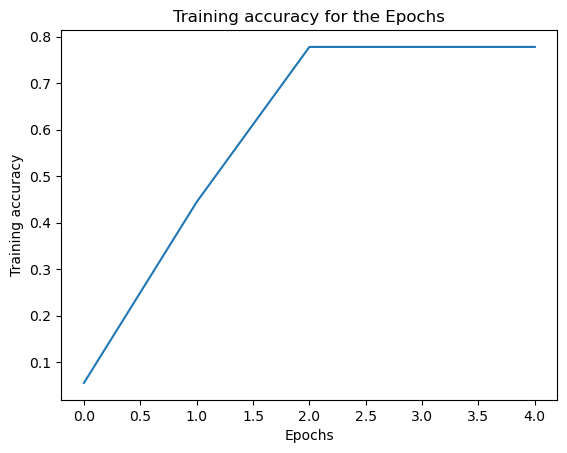

In [52]:
plt.plot(fit_info.history["accuracy"])
plt.title('Training accuracy for the Epochs')
plt.xlabel('Epochs')
plt.ylabel('Training accuracy')

plt.show()